In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('../data/single_pressure/RUN_H_25C-100bar_7.xlsx')

In [3]:
def calculate_flux(
    data: pd.DataFrame,
    flow_rate: float,
    area: float,
    mole_fraction_col: str = 'yCO2',
    time_col: str = 'time'
) -> pd.DataFrame:
    """
    Calculate flux from mole fraction data.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw data with time and mole fraction columns
    flow_rate : float
        Carrier gas flow rate [cm³(STP)/s]
    area : float
        Membrane area [cm²]
    mole_fraction_col : str
        Name of mole fraction column
    time_col : str
        Name of time column
        
    Returns
    -------
    pd.DataFrame
        Data with added 'flux' column [cm³(STP)/(cm²⋅s)]
    """
    # Validate inputs
    if not all(col in data.columns for col in [time_col, mole_fraction_col]):
        raise ValueError(f"Required columns {time_col} and/or {mole_fraction_col} missing")
    
    if flow_rate <= 0 or area <= 0:
        raise ValueError("Flow rate and area must be positive")
    
    # Create copy to avoid modifying original
    df = data.copy()
    
    # Calculate flux
    df['flux'] = df[mole_fraction_col] * flow_rate / area
    
    return df['flux']

In [4]:
diameter = 1.0  # [cm]
area = np.pi * (diameter / 2) ** 2  # [cm²]
flowrate = 8.0  # [cm³(STP)/s]

In [5]:
df['flux'] = calculate_flux(df, flowrate, area)

<Axes: title={'center': 'yCO2'}, xlabel='time'>

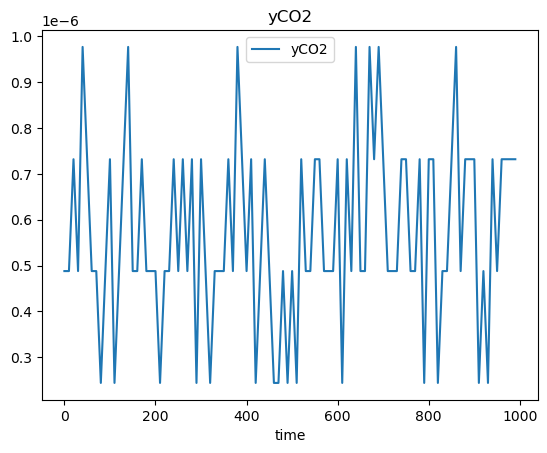

In [6]:
# Noralised flux    #TODO: Add rolling average and exponential smoothing
# Calculate 10-period rolling average and get its maximum value
# rolling_avg_max = df['flux'].rolling(window=10, center=True).mean().max()
rolling_avg = df['flux'].rolling(window=20, center=True).mean()
# Damping factor
damping_factor = 0.1
# Apply exponential smoothing to damp out fluctuations
df['smoothed_flux'] = rolling_avg.ewm(alpha=damping_factor).mean()
rolling_avg_max = df['smoothed_flux'].max()
# Normalize flux by dividing by the maximum rolling average
df['normalised_flux'] = df['flux'] / rolling_avg_max

# Plot
df.iloc[:100].plot(x='time', y='yCO2', title='yCO2')
# df.plot(x='time', y='flux', title='Flux')
# df.plot(x='time', y='normalised_flux', title='Normalised flux')